✅ RDKit 导入成功 (已屏蔽力场警告)
✅ PyG 导入成功
✅ Pymatgen 导入成功
🚀 开始分析流程...
   设备: cuda
   ✅ Scaler 准备就绪
   ✅ 模型加载成功


Inference: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.12s/it]



   生成图表...


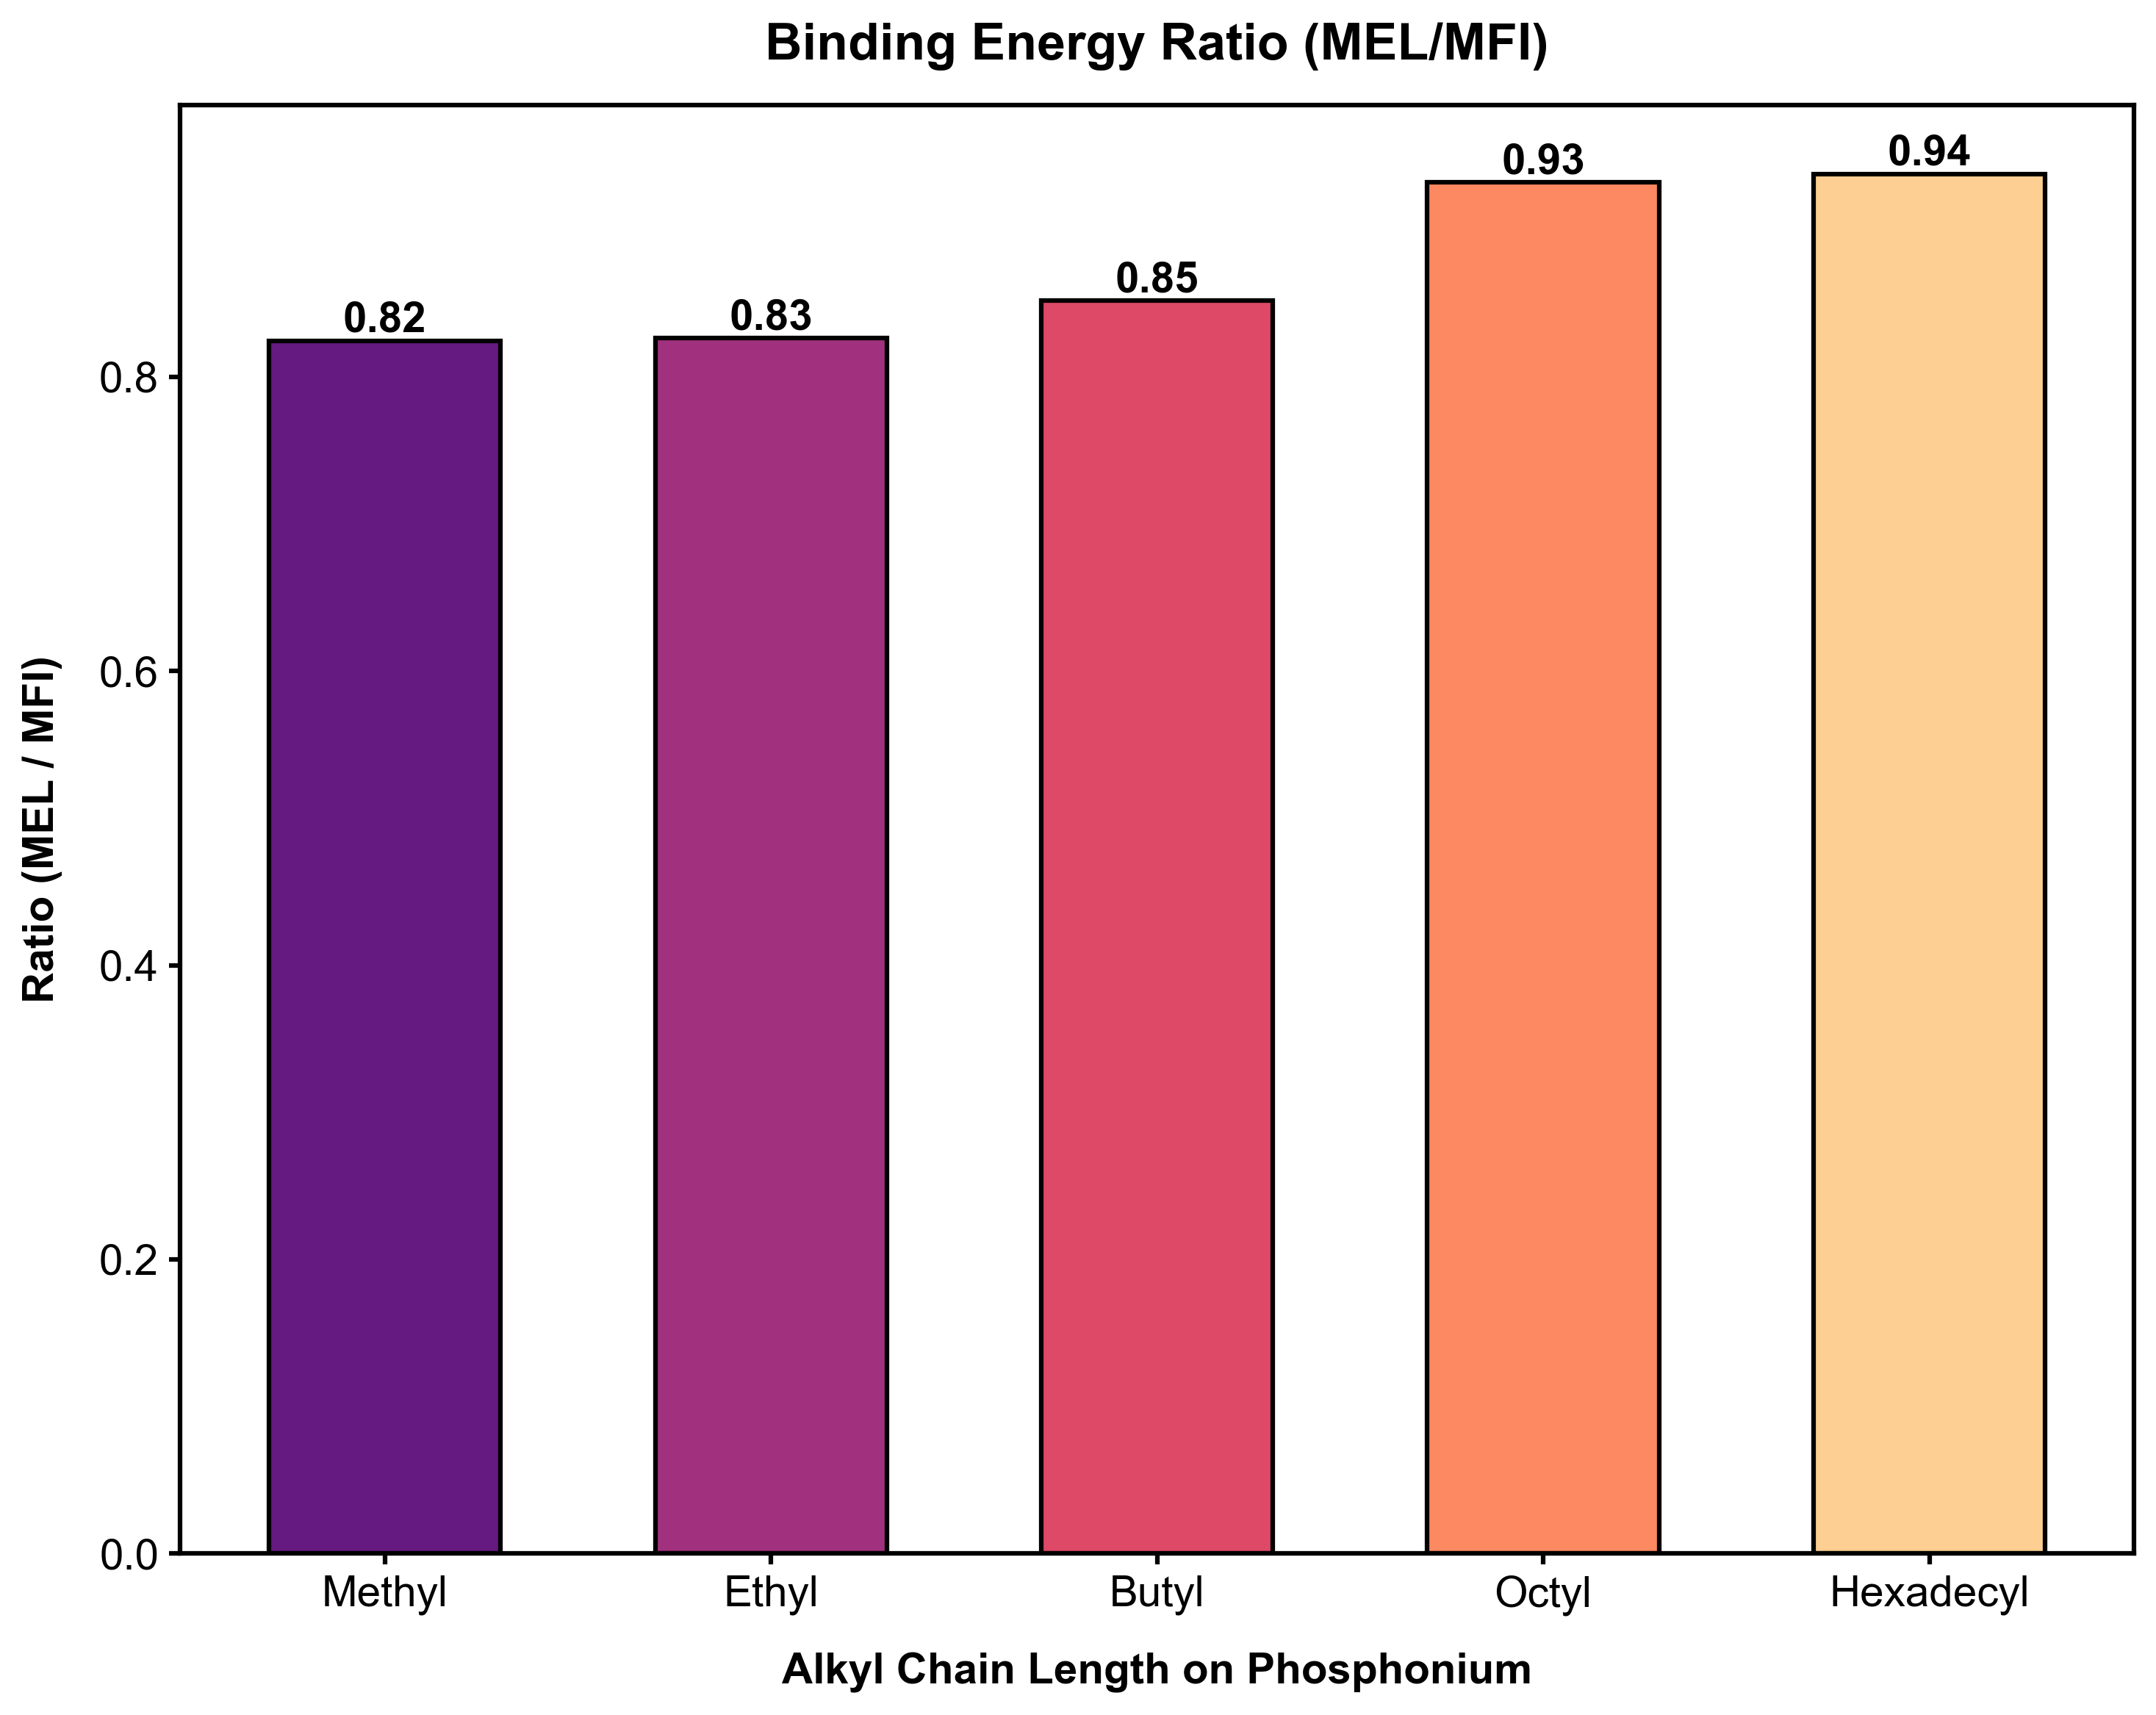

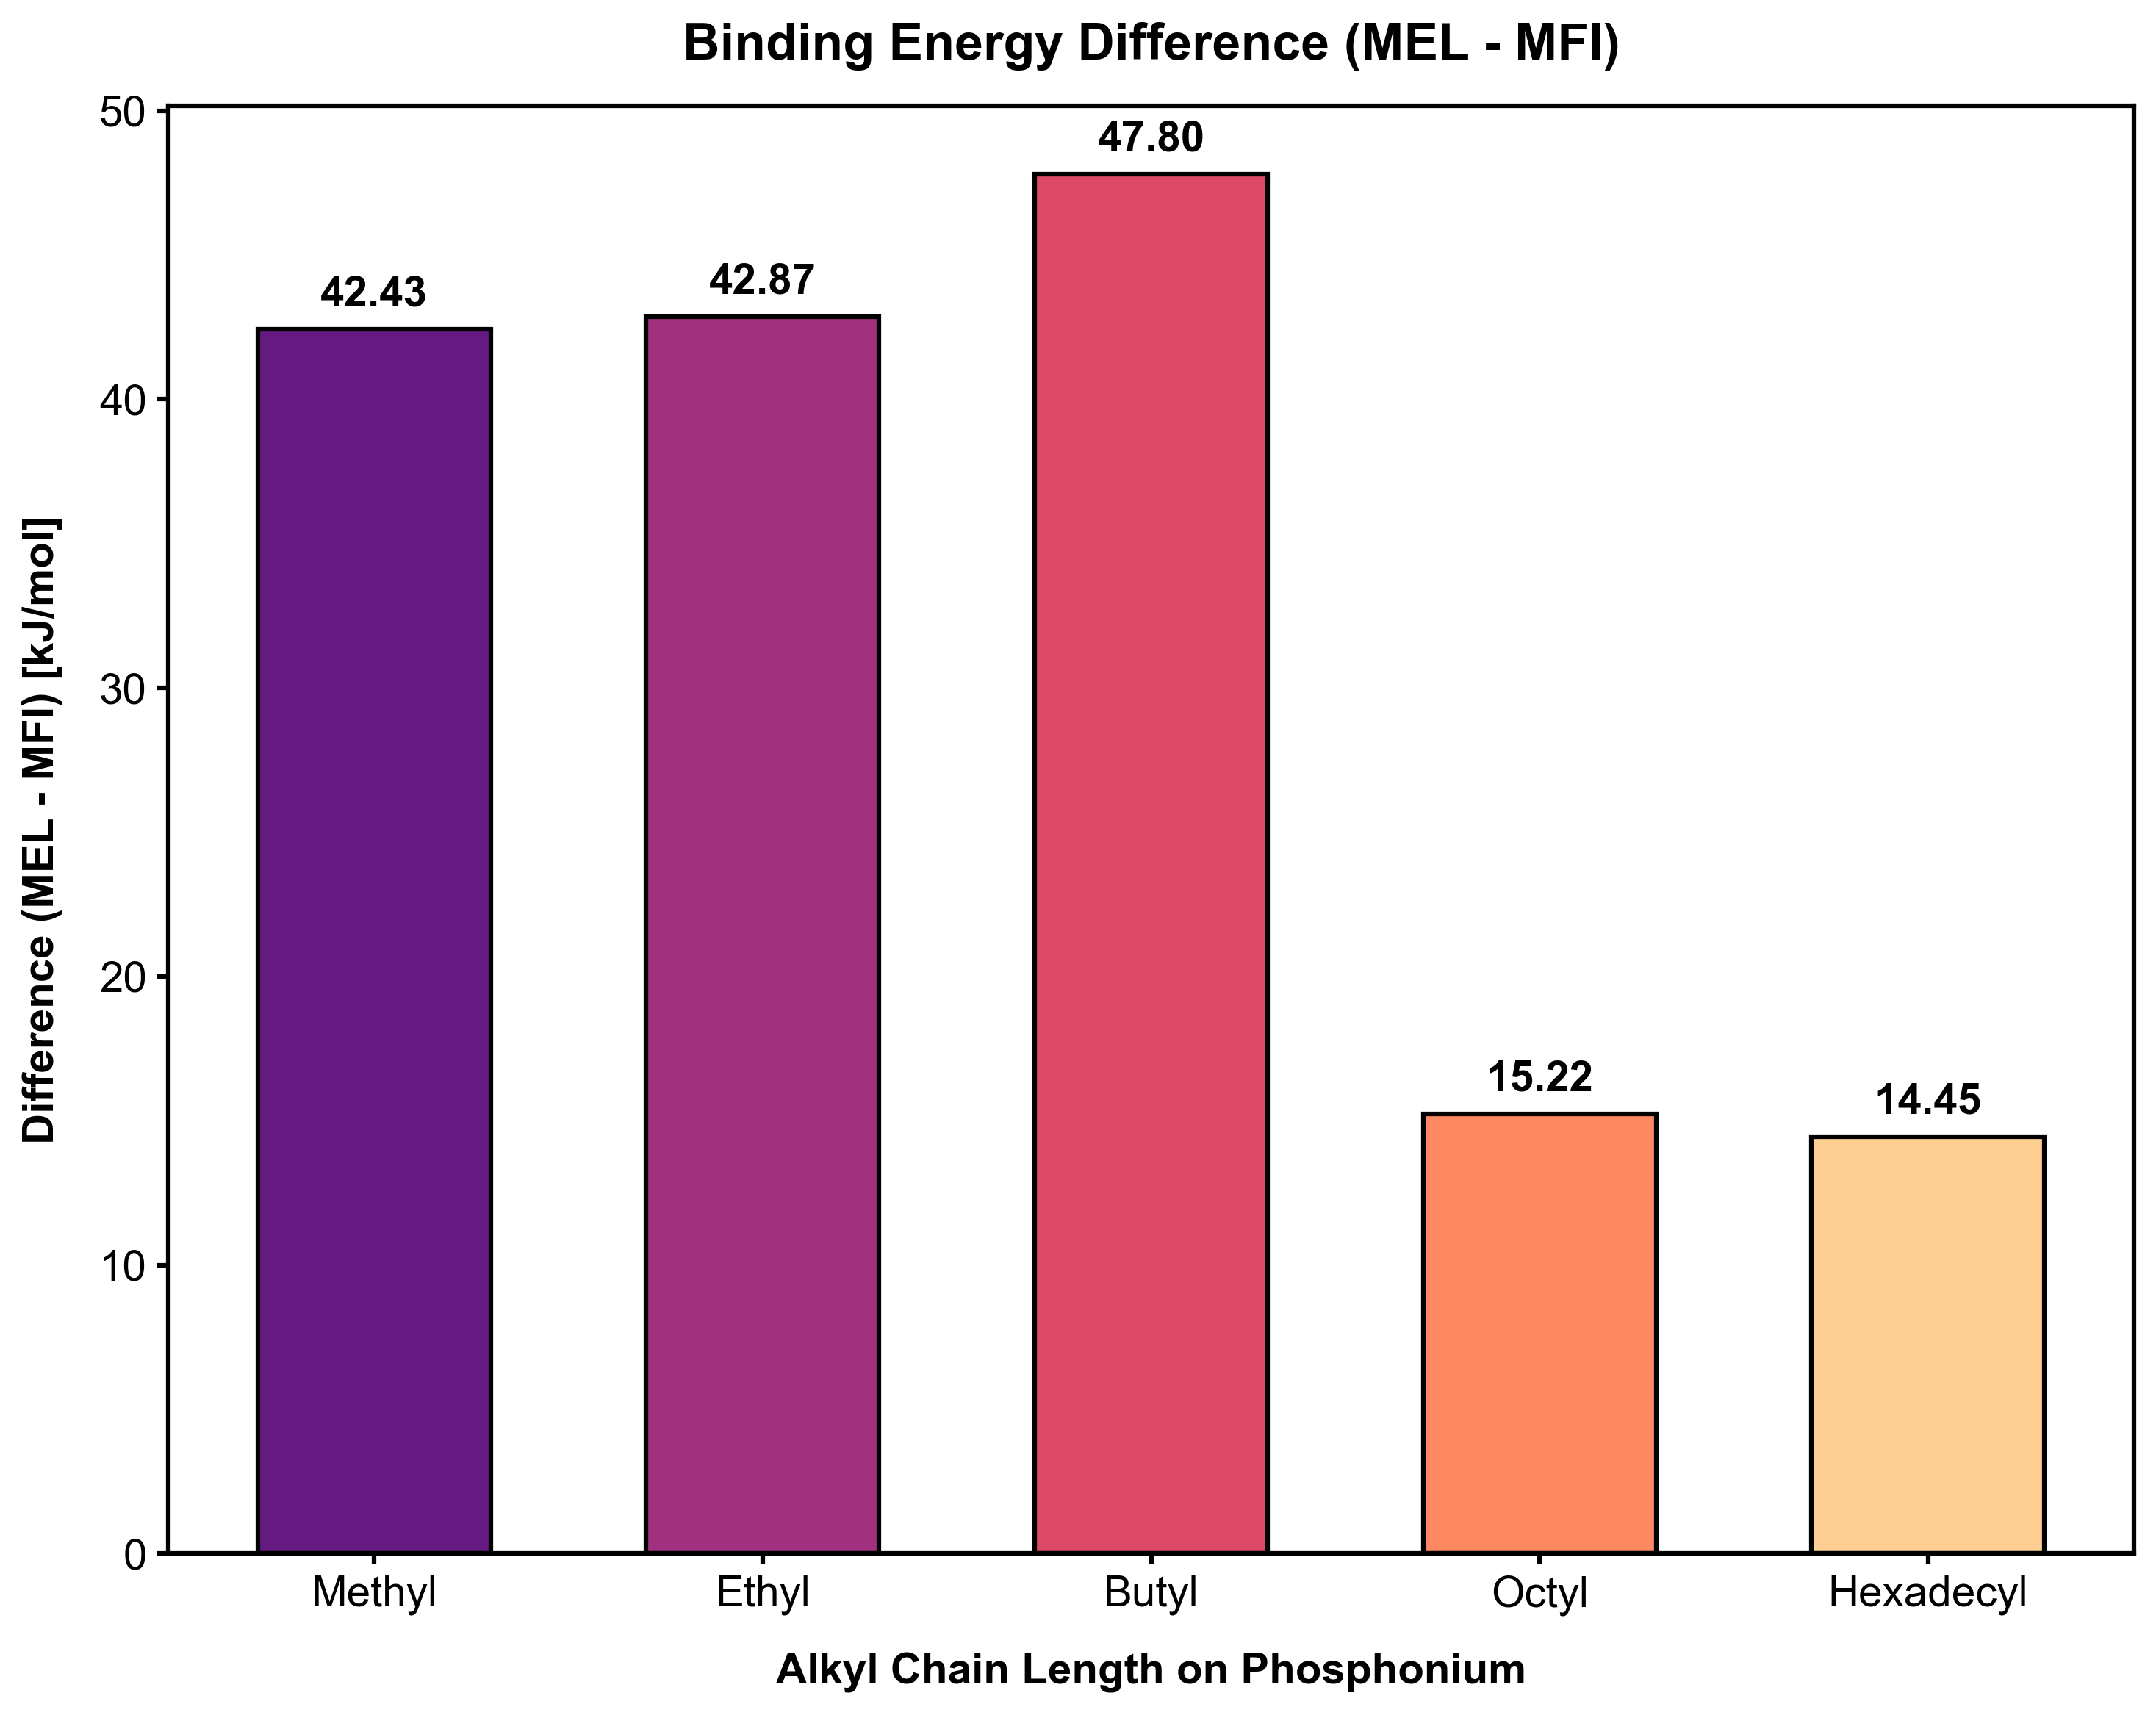

✅ 完成！结果已保存至: C:\Users\admin\Energymodel\2-9


In [ ]:
import os
import json
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import joblib


try:
    from rdkit import Chem, rdBase
    from rdkit.Chem import AllChem, Descriptors
    rdBase.DisableLog('rdApp.error') 
    rdBase.DisableLog('rdApp.warning')
    print("RDKit Imported successfully ")
except ImportError:
    raise ImportError(" rdkit: pip install rdkit")

try:
    from torch_geometric.data import Data, Batch
    from torch_geometric.nn import GCNConv, global_mean_pool
    print(" PyG Imported successfully")
except ImportError:
    raise ImportError(" PyTorch Geometric")

try:
    from pymatgen.core import Structure
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen")
    print(" Pymatgen Imported successfully")
except ImportError:
    raise ImportError(" Pymatgen")

torch.serialization.add_safe_globals([Data, Batch])

class Config:
    BASE_PATH = r"./data"
    DATASET_PATH = os.path.join(BASE_PATH, "Energy_data.xlsx")
    PROCESSED_CACHE_PATH = r"./models/cached_graphs_box64_cleaned.pt"
    MODEL_PATH = r"./models/zeolite_3d_gnn_enriched_cleaned.pth"
    SCALER_SAVE_PATH = r"./models/scaler.pkl"
    
    SAVE_DIR = r"./"
    
    TARGET_COLS = [
        'Binding Energy (kJ/mol Si)',
        'Directivity Energy (kJ/mol Si)',
        'Competition Energy (kJ/mol Si)',
        'Binding Energy (kJ/mol OSDA)',
        'Competition Energy (kJ/mol OSDA)'
    ]
    
    ATOM_EMBEDDING_DIM = 64
    HIDDEN_DIM = 128
    EMB_DIM_DEGREE = 8
    EMB_DIM_CHARGE = 8
    EMB_DIM_HYB = 8
    EMB_DIM_AROMATIC = 4
    EMB_DIM_CHIRAL = 4
    
    VOXEL_SIZE = 64
    VOXEL_RES = 0.5
    SIGMA = 0.5
    CRYSTAL_RADIUS = 6.0
    
    NUM_CONFORMERS_GEN = 200

os.makedirs(Config.SAVE_DIR, exist_ok=True)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

def coords_to_voxel(coords, grid_size=64, res=0.5, sigma=0.5):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    limit = (grid_size * res) / 2.0
    indices = ((coords + limit) / res).astype(int)
    
    for idx in indices:
        x, y, z = idx
        if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
            x_min, x_max = max(0, x-1), min(grid_size, x+2)
            y_min, y_max = max(0, y-1), min(grid_size, y+2)
            z_min, z_max = max(0, z-1), min(grid_size, z+2)
            grid[x_min:x_max, y_min:y_max, z_min:z_max] += 1.0
    return np.clip(grid, 0, 1.0)

class GraphBuilder:
    def _get_rich_atom_features(self, atom=None, element_symbol=None, is_crystal=False):
        if atom:
            atomic_num = atom.GetAtomicNum()
        elif element_symbol:
            try: atomic_num = Chem.GetPeriodicTable().GetAtomicNumber(element_symbol)
            except: atomic_num = 0
        else:
            atomic_num = 0
            
        feat_atomic = min(atomic_num, 118)
        
        if is_crystal or atom is None:
            return [feat_atomic, 0, 5, 0, 0, 0] 

        degree = min(atom.GetDegree(), 10)
        charge_idx = max(0, min(atom.GetFormalCharge() + 5, 14))
        
        hyb_map = {
            Chem.rdchem.HybridizationType.S: 0, Chem.rdchem.HybridizationType.SP: 1, 
            Chem.rdchem.HybridizationType.SP2: 2, Chem.rdchem.HybridizationType.SP3: 3,
            Chem.rdchem.HybridizationType.SP3D: 4, Chem.rdchem.HybridizationType.SP3D2: 5,
            Chem.rdchem.HybridizationType.UNSPECIFIED: 6
        }
        hyb_idx = hyb_map.get(atom.GetHybridization(), 6)
        is_aromatic = 1 if atom.GetIsAromatic() else 0
        chi_map = {
            Chem.rdchem.ChiralType.CHI_UNSPECIFIED: 0, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW: 1,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW: 2, Chem.rdchem.ChiralType.CHI_OTHER: 3
        }
        chi_idx = chi_map.get(atom.GetChiralTag(), 0)
        
        return [feat_atomic, degree, charge_idx, hyb_idx, is_aromatic, chi_idx]

    def _calculate_shape_descriptors(self, coords):
        if coords is None or len(coords) < 2: return [0.0] * 10
        coords = coords - np.mean(coords, axis=0)
        try:
            evals, _ = np.linalg.eigh(np.cov(coords.T))
            evals = sorted(evals, reverse=True)
            pm1 = max(evals[0], 1e-6)
            pm2 = evals[1] if len(evals) > 1 else 0.0
            pm3 = evals[2] if len(evals) > 2 else 0.0
            rg = np.sqrt(np.mean(np.sum(coords**2, axis=1)))
            return [rg, pm1, pm2, pm3, 0, 0, pm3/pm1, 0, 0, 0]
        except:
            return [0.0] * 10

    def process_molecule(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if not mol: return None
            mol = Chem.AddHs(mol)
            
            params = AllChem.ETKDGv3() 
            params.randomSeed = 42
            params.useSmallRingTorsions = True
            
            cids = AllChem.EmbedMultipleConfs(mol, numConfs=Config.NUM_CONFORMERS_GEN, params=params)
            
            if len(cids) > 0:
                try:
                    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
                except:
                    pass 
            else:
                return None
            
            best_cid = -1
            max_span = -1.0
            for cid in cids:
                conf = mol.GetConformer(cid)
                pos = conf.GetPositions()
                dist_sq = np.sum((pos[:, np.newaxis, :] - pos[np.newaxis, :, :]) ** 2, axis=-1)
                current_span = np.sqrt(np.max(dist_sq))
                if current_span > max_span:
                    max_span = current_span
                    best_cid = cid
            
            conf = mol.GetConformer(best_cid)
            pos = conf.GetPositions()
            pos = pos - np.mean(pos, axis=0)
            
            atom_features = [self._get_rich_atom_features(atom=atom) for atom in mol.GetAtoms()]
            x = torch.tensor(atom_features, dtype=torch.long)
            
            edge_indices, edge_weights = [], []
            for bond in mol.GetBonds():
                u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                dist = np.linalg.norm(pos[u] - pos[v])
                w = 1.0 / (dist + 0.1)
                edge_indices.extend([[u, v], [v, u]])
                edge_weights.extend([w, w])
            
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weights, dtype=torch.float)
            
            AllChem.ComputeGasteigerCharges(mol)
            charges = [float(atom.GetProp('_GasteigerCharge')) if atom.HasProp('_GasteigerCharge') else 0.0 for atom in mol.GetAtoms()]
            x_charge = torch.tensor(charges, dtype=torch.float).unsqueeze(1)
            
            shape_feats = self._calculate_shape_descriptors(pos)
            global_props = [
                Descriptors.MolLogP(mol), Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
                Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol), 0.0, float(Chem.GetFormalCharge(mol)),
            ] + shape_feats
            
            if len(global_props) > 17: global_props = global_props[:17]
            while len(global_props) < 17: global_props.append(0.0)
            
            return Data(
                x=x, edge_index=edge_index, edge_weight=edge_weight,
                x_charge=x_charge, global_attr=torch.tensor(global_props, dtype=torch.float).unsqueeze(0),
                pos=torch.tensor(pos, dtype=torch.float)
            )
        except Exception as e:
            # print(f"Error processing molecule {smiles}: {e}")
            return None

    def process_zeolite(self, topology):
        patterns = [
            os.path.join(Config.CIF_PATH, f"{topology}.cif"),
            os.path.join(Config.CIF_PATH, f"{topology}.cif_"),
            os.path.join(Config.CIF_PATH, f"*{topology}*.cif"),
            os.path.join(Config.CIF_PATH, f"*{topology}*.cif_")
        ]
        cif_file = None
        for p in patterns:
            files = glob.glob(p)
            if files:
                cif_file = files[0]
                break
        
        if not cif_file:
            print(f"can't find {topology}")
            return None
            
        try:
            struct = Structure.from_file(cif_file)
            atom_feats = [self._get_rich_atom_features(element_symbol=s.specie.symbol, is_crystal=True) for s in struct]
            x = torch.tensor(atom_feats, dtype=torch.long)
            pos = torch.tensor(struct.cart_coords, dtype=torch.float)
            
            nbrs = struct.get_all_neighbors(r=Config.CRYSTAL_RADIUS, include_index=True)
            edge_indices = []
            for i, nbr_list in enumerate(nbrs):
                for nbr in sorted(nbr_list, key=lambda x: x[1])[:12]:
                    edge_indices.append([i, nbr[2]])
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            
            struct_super = struct.copy()
            struct_super.make_supercell([3, 3, 3])
            pos_super = torch.tensor(struct_super.cart_coords, dtype=torch.float)
            pos_super = pos_super - torch.mean(pos_super, dim=0)
            
            return Data(x=x, edge_index=edge_index, pos=pos, pos_super=pos_super)
        except Exception as e:
            return None

class Voxel3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)
        self.fc = nn.Linear(64 * 8 * 8 * 8, 128)
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

class DualBranchGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_atom = nn.Embedding(120, Config.ATOM_EMBEDDING_DIM)
        self.emb_degree = nn.Embedding(12, Config.EMB_DIM_DEGREE)
        self.emb_charge = nn.Embedding(15, Config.EMB_DIM_CHARGE)
        self.emb_hyb = nn.Embedding(8, Config.EMB_DIM_HYB)
        self.emb_aromatic = nn.Embedding(2, Config.EMB_DIM_AROMATIC)
        self.emb_chiral = nn.Embedding(4, Config.EMB_DIM_CHIRAL)
        
        total_emb_dim = (Config.ATOM_EMBEDDING_DIM + Config.EMB_DIM_DEGREE + 
                         Config.EMB_DIM_CHARGE + Config.EMB_DIM_HYB + 
                         Config.EMB_DIM_AROMATIC + Config.EMB_DIM_CHIRAL)
        
        self.mol_conv1 = GCNConv(total_emb_dim + 1, Config.HIDDEN_DIM)
        self.mol_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.zeo_conv1 = GCNConv(total_emb_dim, Config.HIDDEN_DIM)
        self.zeo_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.voxel_cnn = Voxel3DCNN()
        
        self.global_encoder = nn.Sequential(
            nn.Linear(17, 64), nn.ReLU(),
            nn.Linear(64, Config.HIDDEN_DIM), nn.BatchNorm1d(Config.HIDDEN_DIM), nn.ReLU()
        )
        
        fusion_dim = Config.HIDDEN_DIM * 4
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, len(Config.TARGET_COLS))
        )

    def _embed_features(self, x_idx):
        return torch.cat([
            self.emb_atom(x_idx[:, 0]), self.emb_degree(x_idx[:, 1]),
            self.emb_charge(x_idx[:, 2]), self.emb_hyb(x_idx[:, 3]),
            self.emb_aromatic(x_idx[:, 4]), self.emb_chiral(x_idx[:, 5])
        ], dim=1)

    def forward(self, mol_batch, zeo_batch, voxel_batch):
        x_m = torch.cat([self._embed_features(mol_batch.x), mol_batch.x_charge], dim=1)
        x_m = F.relu(self.mol_conv2(F.relu(self.mol_conv1(x_m, mol_batch.edge_index, edge_weight=mol_batch.edge_weight)), mol_batch.edge_index, edge_weight=mol_batch.edge_weight))
        feat_m = global_mean_pool(x_m, mol_batch.batch)
        
        x_z = self._embed_features(zeo_batch.x)
        x_z = F.relu(self.zeo_conv2(F.relu(self.zeo_conv1(x_z, zeo_batch.edge_index)), zeo_batch.edge_index))
        feat_z = global_mean_pool(x_z, zeo_batch.batch)
        
        feat_v = self.voxel_cnn(voxel_batch)
        feat_g = self.global_encoder(mol_batch.global_attr.squeeze(1) if mol_batch.global_attr.dim()==3 else mol_batch.global_attr)
        
        return self.head(torch.cat([feat_m, feat_z, feat_g, feat_v], dim=1))

def run_analysis():
    print("Start analysis...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"  : {device}")

    # 1. Scaler
    if os.path.exists(Config.DATASET_PATH):
        df = pd.read_excel(Config.DATASET_PATH, engine='openpyxl')
        targets = df[Config.TARGET_COLS].values
        targets = targets[~np.isnan(targets).any(axis=1)]
        scaler = StandardScaler().fit(targets)
        mean_vec, std_vec = scaler.mean_, scaler.scale_
        joblib.dump(scaler, Config.SCALER_SAVE_PATH)
        print("   Scaler ready.")
    else:
        print("   No dataset found")
        mean_vec, std_vec = np.zeros(len(Config.TARGET_COLS)), np.ones(len(Config.TARGET_COLS))

    model = DualBranchGNN().to(device)
    if os.path.exists(Config.MODEL_PATH):
        model.load_state_dict(torch.load(Config.MODEL_PATH, map_location=device, weights_only=True))
        model.eval()
        print("  Model loaded successfully")
    else:
        print(f"   Can't find the model.: {Config.MODEL_PATH}")
        return

    # 3. 数据
    molecules = [
        {"name": "Methyl", "cid": 2760115, "smiles": "CCCC[P+](C)(CCCC)CCCC"},
        {"name": "Ethyl", "cid": 18386502, "smiles": "CC[P+](CCCC)(CCCC)CCCC"}, 
        {"name": "Butyl", "cid": 75312, "smiles": "CCCC[P+](CCCC)(CCCC)CCCC"},
        {"name": "Octyl", "cid": 20519090, "smiles": "CCCC[P+](CCCCCCCC)(CCCC)CCCC"},
        {"name": "Hexadecyl", "cid": 23086902, "smiles": "CCCC[P+](CCCCCCCCCCCCCCCC)(CCCC)CCCC"}
    ]
    zeolites = ["MEL", "MFI"]
    gb = GraphBuilder()
    zeo_graphs = {}
    
    for z in zeolites:
        g = gb.process_zeolite(z)
        if g: zeo_graphs[z] = g
    
    results = {m['name']: {} for m in molecules}
    target_idx = 3

    for mol_info in tqdm(molecules, desc="Inference"):
        mol_data = gb.process_molecule(mol_info['smiles'])
        if not mol_data: continue
            
        for z_name in zeolites:
            if z_name not in zeo_graphs: continue
            zeo_data = zeo_graphs[z_name]
            
            grid_mol = coords_to_voxel(mol_data.pos.numpy(), Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
            grid_zeo = coords_to_voxel(zeo_data.pos_super.numpy(), Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
            voxel = torch.tensor(np.stack([grid_mol, grid_zeo], axis=0), dtype=torch.float).unsqueeze(0).to(device)
            m_batch = Batch.from_data_list([mol_data]).to(device)
            z_batch = Batch.from_data_list([zeo_data]).to(device)
            
            with torch.no_grad():
                pred_norm = model(m_batch, z_batch, voxel).cpu().numpy()[0]
            
            pred_real = pred_norm * std_vec + mean_vec
            results[mol_info['name']][z_name] = pred_real[target_idx]

    print("\n   Generate Charts...")
    names = [m['name'] for m in molecules]
    mel_vals = np.array([results[n].get('MEL', 0) for n in names])
    mfi_vals = np.array([results[n].get('MFI', 0) for n in names])
    
    ratio_vals = np.divide(mel_vals, mfi_vals, out=np.zeros_like(mel_vals), where=mfi_vals!=0)
    diff_vals = mel_vals - mfi_vals
    colors = plt.cm.magma(np.linspace(0.3, 0.9, len(names)))
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    bars = ax.bar(names, ratio_vals, color=colors, edgecolor='black', linewidth=1.5, width=0.6)
    ax.set_ylabel("Ratio (MEL / MFI)", fontweight='bold', labelpad=12)
    ax.set_xlabel("Alkyl Chain Length on Phosphonium", fontweight='bold', labelpad=12)
    ax.set_title("Binding Energy Ratio (MEL/MFI)", fontweight='bold', pad=15)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.SAVE_DIR, "Figure_1_MEL_MFI_Ratio.png"))
    plt.show()
    
    # Diff Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    bars = ax.bar(names, diff_vals, color=colors, edgecolor='black', linewidth=1.5, width=0.6)
    ax.set_ylabel("Difference (MEL - MFI) [kJ/mol]", fontweight='bold', labelpad=12)
    ax.set_xlabel("Alkyl Chain Length on Phosphonium", fontweight='bold', labelpad=12)
    ax.set_title("Binding Energy Difference (MEL - MFI)", fontweight='bold', pad=15)
    for bar in bars:
        h = bar.get_height()
        offset = 0.5 if h >= 0 else -1.5
        ax.text(bar.get_x() + bar.get_width()/2, h + offset, f'{h:.2f}', ha='center', va='bottom' if h>0 else 'top', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.SAVE_DIR, "Figure_2_MEL_MFI_Diff.png"))
    plt.show()
    
    print(f"chart saved: {Config.SAVE_DIR}")

if __name__ == "__main__":
    run_analysis()